# 试穿演示

## 开始演示

In [1]:
dp_dir="ACGPN/Data_preprocessing"
!rm {dp_dir}/test_color/*
!rm {dp_dir}/test_edge/*
!rm {dp_dir}/test_img/*
!rm {dp_dir}/test_label/*
!rm {dp_dir}/test_pose/*

rm: cannot remove 'ACGPN/Data_preprocessing/test_color/*': No such file or directory
rm: cannot remove 'ACGPN/Data_preprocessing/test_edge/*': No such file or directory
rm: cannot remove 'ACGPN/Data_preprocessing/test_img/*': No such file or directory
rm: cannot remove 'ACGPN/Data_preprocessing/test_label/*': No such file or directory
rm: cannot remove 'ACGPN/Data_preprocessing/test_pose/*': No such file or directory


## 两种方式设置输入文件
### 方式一：设置文件地址

In [2]:
# 衣服模特地址
src = "001073_0.jpg"

# 试穿模特地址
dst = "000174_0.jpg"

### 方式二：上传文件

In [ ]:
from google.colab import files

# 先上传衣服模特
uploaded_src = files.upload()
for name in uploaded_src.keys():
    src = name

# 再上传试穿模特
uploaded_dst = files.upload()
for name in uploaded_dst.keys():
    dst = name

## 调整图片尺寸

In [3]:
import numpy as np
from PIL import Image
import os

src_name = f"{src.split('.')[0]}.png"
dst_name = f"{dst.split('.')[0]}.png"

# 在test_pairs中记录配对信息
with open('ACGPN/Data_preprocessing/test_pairs.txt','w') as f:
    f.write(f'{dst_name} {src_name}')

# 将衣服模特图片放在test_color中
cloth = Image.open(src)
cloth = cloth.resize((192, 256), Image.BICUBIC).convert('RGB')
cloth.save(os.path.join('ACGPN/Data_preprocessing/test_color', src_name))

# 将试穿模特图片放在test_img中
img = Image.open(dst)
img = img.resize((192,256), Image.BICUBIC)
img.save(os.path.join('ACGPN/Data_preprocessing/test_img', dst_name))

## 计算试穿模特的姿势

In [4]:
from ACGPN.predict_pose import generate_pose_keypoints
img_path = os.path.join('ACGPN/Data_preprocessing/test_img', dst_name)
# 试穿模特的姿势保存在test_pose中
pose_path = os.path.join('ACGPN/Data_preprocessing/test_pose', dst_name[:-4]+'_keypoints.json')
generate_pose_keypoints(img_path, pose_path)

File saved at ACGPN/Data_preprocessing/test_pose/000174_0_keypoints.json


## 对衣服模特进行分割

In [5]:
os.environ['MKL_THREADING_LAYER'] = 'GNU'
# 试穿模特衣服mask保存在test_edge中
!python schp/upcloth_extractor.py

Evaluating total class number 20 with ['Background', 'Hat', 'Hair', 'Glove', 'Sunglasses', 'Upper-clothes', 'Dress', 'Coat', 'Socks', 'Pants', 'Jumpsuits', 'Scarf', 'Skirt', 'Face', 'Left-arm', 'Right-arm', 'Left-leg', 'Right-leg', 'Left-shoe', 'Right-shoe']
100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.43it/s]


## 对试穿模特进行分割

In [6]:
# 对test_img中试穿模特的衣服进行分割
# 试穿模特衣服mask保存在test_label中
!python schp/simple_extractor.py

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.80it/s]


## 使用ACGPN生成试穿结果

In [7]:
# 综合衣服模特图片、衣服模特mask、试穿模特图片、试穿模特mask和模特pose进行生成
!python ACGPN/test.py

?
CustomDatasetDataLoader
dataset [AlignedDataset] was created
# Inference images = 1
latest_net_U.pth
latest_net_G1.pth
latest_net_G2.pth
latest_net_G.pth
/home/mugle/anaconda3/lib/python3.8/site-packages/torchvision/transforms/transforms.py:285: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +
/home/mugle/anaconda3/lib/python3.8/site-packages/torchvision/transforms/transforms.py:257: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(
Traceback (most recent call last):
  File "ACGPN/test.py", line 126, in <module>
    main()
  File "ACGPN/test.py", line 102, in main
    fake_image, warped_cloth, refined_cloth = model(Variable(data['label'].cuda()), Variable(data['edge'].cuda()), Variable(img_fore.cuda()), Variable(
  File "/home/mugle/anaconda3/lib/python3.8/sit

## 显示试穿结果

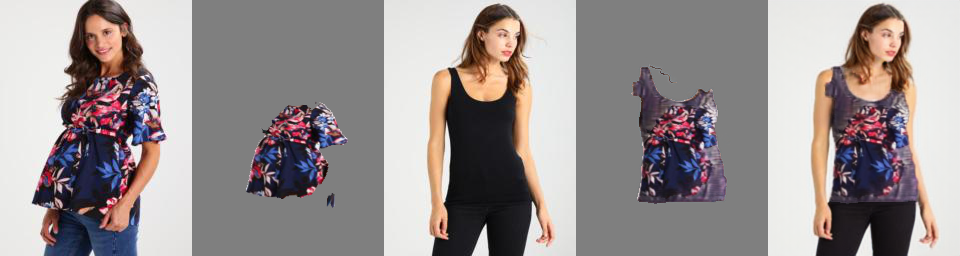

In [8]:
output_grid = np.concatenate([
                np.array(Image.open(f'ACGPN/Data_preprocessing/test_color/{src_name}')),
                np.array(Image.open(f'results/warped-cloth_{dst_name}')),
                np.array(Image.open(f'ACGPN/Data_preprocessing/test_img/{dst_name}')),
                np.array(Image.open(f'results/refined-cloth_{dst_name}')),
                np.array(Image.open(f'results/try-on_{dst_name}'))
                ], axis=1)
image_grid = Image.fromarray(output_grid)
image_grid.save(f"results/{src_name[:-4]}-on-{dst_name}")
image_grid